<a href="https://colab.research.google.com/github/krits29/regeneron-house-waste/blob/main/regeneron_house_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('regeneron-house-waste')
jovian.set_colab_id('17GG0OShLzQycPgbwwRcEOjGCWc-vV6Lr')

     |████████████████████████████████| 68 kB 4.6 MB/s 


# regeneron-house-waste

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [3]:
import jovian

In [4]:
# Execute this to save new versions of the notebook
jovian.commit(project="regeneron-house-waste")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/krits29/regeneron-house-waste


'https://jovian.ai/krits29/regeneron-house-waste'

In [5]:
# Using 'opendatasets' and download https://www.kaggle.com/mostafaabla/garbage-classification

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

In [8]:
dataset_url = "https://www.kaggle.com/mostafaabla/garbage-classification"

In [10]:
od.download(dataset_url)


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: krits29
Your Kaggle Key: ··········


100%|██████████| 239M/239M [00:05<00:00, 47.6MB/s]


In [11]:
# import dataset into pytorch

In [12]:
data_dir = "./garbage-classification/garbage_classification"

In [13]:
import os

In [14]:
os.listdir(data_dir)

['shoes',
 'brown-glass',
 'green-glass',
 'plastic',
 'white-glass',
 'battery',
 'biological',
 'metal',
 'clothes',
 'cardboard',
 'paper',
 'trash']

In [15]:
# use ImageFolder class from torchvision

In [16]:
for cls in os.listdir(data_dir):
  print(cls, len(os.listdir(data_dir + "/" + cls)))

shoes 1977
brown-glass 607
green-glass 629
plastic 865
white-glass 775
battery 945
biological 985
metal 769
clothes 5325
cardboard 891
paper 1050
trash 697


## Import Dataset into Pytorch

In [17]:
from torchvision.datasets import ImageFolder

In [18]:
dataset = ImageFolder(data_dir)

In [19]:
len(dataset)

15515

In [20]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=280x180 at 0x7F0437FF3990>, 0)

In [21]:
dataset.classes

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

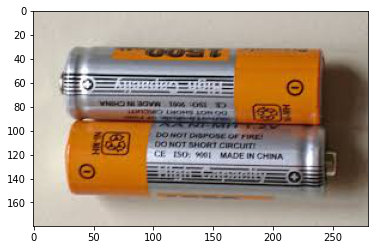

In [23]:
img, label = dataset[0]
plt.imshow(img)

In [24]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))

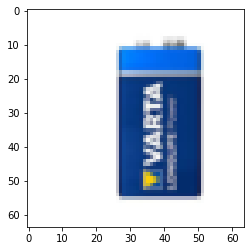

In [25]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

In [26]:
# split dataset into validation and trainig dataset

In [27]:
val_percentage = 0.1
val_size = int(val_percentage * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(13964, 1551)

In [28]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(13964, 1551)

In [29]:
from torch.utils.data import DataLoader

batch_size = 128
# dataloader
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [30]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


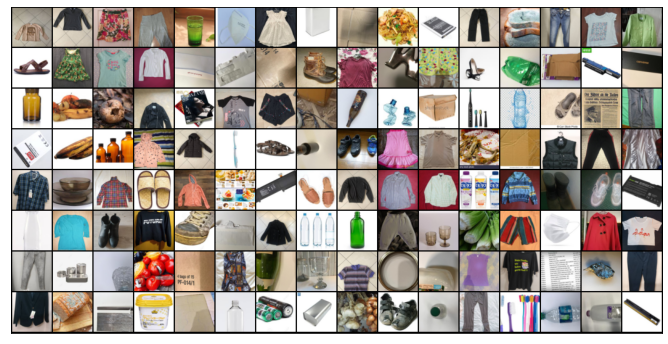

In [31]:
show_batch(train_dl)

### Utility Functions and Classes

### GPU Utilities

In [32]:
import torch

# Use GPU is available, else CPU
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

# Move tensors to the gpu/cpu
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  # Wrap dataloader to move data to a device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  # Yield batch of data after moving data to device
  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  # Return number of batches
  def __len__(self):
    return len(self.dl)

In [33]:
torch.cuda.is_available()

True

In [34]:
device = get_default_device()
device

device(type='cuda')

In [35]:
img, label = dataset[0]

In [36]:
img.shape

torch.Size([3, 64, 64])

In [37]:
img.device

device(type='cpu')

In [38]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

### Model and Training Utilities

In [39]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    # calculate loss for a batch of training data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    # calculate loss and accuract for a batch of validation data
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels) # calculate loss
    acc = accuracy(out, labels)         # calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
    
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [40]:
@torch.no_grad()
def evaluate(model, val_loader):
  #Evaluates the model's performance on the validation data set
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Train
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    #Validation
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Model

In [41]:
def conv_block(in_channels, out_channels, pool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.conv1 = conv_block(in_channels, 64)
    self.conv2 = conv_block(64, 128, pool=True)
    self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv3 = conv_block(128, 256, pool=True)
    self.conv4 = conv_block(256, 512, pool=True)
    self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))
    
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out


In [42]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [43]:
model.conv1[0].weight.device

device(type='cuda', index=0)

## Passing one batch of input tensors into model

In [44]:
for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


preds.shape torch.Size([128, 12])


## Training

In [45]:
history = [evaluate(model, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.04867788404226303, 'val_loss': 2.4838151931762695}]

In [46]:
history += fit(5, 0.001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.3961, val_loss: 1.0928, val_acc: 0.6390
Epoch [1], train_loss: 1.0336, val_loss: 0.9111, val_acc: 0.6898
Epoch [2], train_loss: 0.8824, val_loss: 0.8264, val_acc: 0.7508
Epoch [3], train_loss: 0.8193, val_loss: 0.7335, val_acc: 0.7641
Epoch [4], train_loss: 0.7275, val_loss: 0.7933, val_acc: 0.7583


In [52]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.3485, val_loss: 0.5053, val_acc: 0.8527
Epoch [1], train_loss: 0.3137, val_loss: 0.4695, val_acc: 0.8638
Epoch [2], train_loss: 0.2867, val_loss: 0.4595, val_acc: 0.8623
Epoch [3], train_loss: 0.2695, val_loss: 0.4533, val_acc: 0.8563
Epoch [4], train_loss: 0.2592, val_loss: 0.4421, val_acc: 0.8738


In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

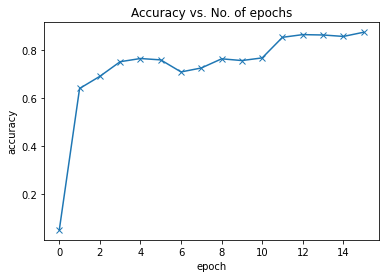

In [54]:
plot_accuracies(history)

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

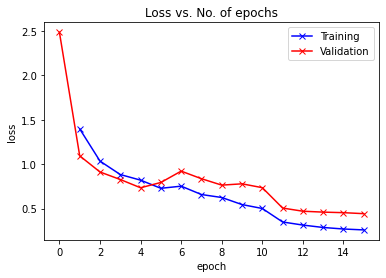

In [56]:
plot_losses(history)

## Record Results